# Introduction

See PyTorch's [Data Loading and Processing Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import dill as pickle
import itertools
from datetime import datetime
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 40)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [12, 4]

from sklearn.metrics import confusion_matrix

from utils import *

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

# Simulated prices

## Data Generation

In [4]:
def sim_path(N=500, sigma=0.35, S0=1, dt=1/250,
             mu=[0.05, 0.05], P=np.array([[0.95, 0.05], [0.1, 0.9]]),
             wdt_hl=2):
    
    # State simulation
    state = np.random.randint(0, 2)
    states = [state]
    for t in range(N - 1):
        state = int(np.random.multinomial(1, P[state, :]).argmax())
        states.append(state)
    
    # Price simulation
    drift = (np.array([mu[s] for s in states[1:]]) - 0.5 * sigma**2) * dt
    wiener = np.random.randn(N - 1) * sigma * np.sqrt(dt)

    S = S0 * np.concatenate((np.ones(1), np.exp(np.cumsum(drift + wiener))))
    
    res_df = DataFrame(data=dict(Close=S))
    res_df = res_df.assign(Date = pd.date_range(start=datetime(2018, 1, 1),
                                                periods=N, freq='D')).set_index('Date')
    
    res_df = res_df.assign(Open = res_df.Close.shift(-1).fillna(method='ffill') * \
                                    np.exp((np.random.rand(N) - 0.5) * sigma * np.sqrt(dt)))
    
    res_df = res_df.assign(High = res_df[['Open', 'Close']].max(axis=1) * \
                                np.exp(np.random.rand(N) * wdt_hl * sigma * np.sqrt(dt)),
                           Low = res_df[['Open', 'Close']].min(axis=1) * \
                                np.exp(- np.random.rand(N) * wdt_hl * sigma * np.sqrt(dt)))

    return res_df[['Open', 'High', 'Low', 'Close']]

In [5]:
price_df = add_changes(clean_trends(find_trends(sim_path())))
price_df

,Open,High,Low,Close,Smoothed,Trend,n_Trend,Max_Drawdown,ATR,max_TR,min_TR,Ratio,ICAGR,Bliss,Trend_Start,Trend_End,Ch,Ch2,Ch3,Ch4
Date,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.994739,1.039616,0.987976,1.000000,0.977322,1.0,1.0,0.149232,0.065055,0.118758,0.016359,1.248733,0.582091,3.900589,2018-01-01,2018-05-20,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
2018-01-02,0.971798,1.002698,0.954783,0.995955,0.977348,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-05-20,-0.004053,1.642956e-05,-6.659458e-08,2.699305e-10
2018-01-03,1.009619,1.049435,0.976765,0.977162,0.977391,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-05-20,-0.019050,3.628986e-04,-6.913181e-06,1.316954e-07
2018-01-04,1.001809,1.046206,0.959566,1.013802,0.977452,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-05-20,0.036811,1.355031e-03,4.987969e-05,1.836109e-06
2018-01-05,1.003713,1.008949,0.988042,1.001233,0.977531,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-05-20,-0.012475,1.556380e-04,-1.941661e-06,2.422318e-08
2018-01-06,0.991941,1.037951,0.951376,1.001374,0.977628,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-05-20,0.000141,1.976604e-08,2.778942e-12,3.906964e-16
2018-01-07,0.987532,1.006431,0.973565,0.989944,0.977744,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-05-20,-0.011480,1.317813e-04,-1.512797e-06,1.736631e-08
2018-01-08,1.034804,1.041502,0.936010,0.976938,0.977880,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-05-20,-0.013226,1.749157e-04,-2.313360e-06,3.059551e-08
2018-01-09,0.961432,1.055006,0.945284,1.024255,0.978034,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-05-20,0.047298,2.237088e-03,1.058095e-04,5.004562e-06


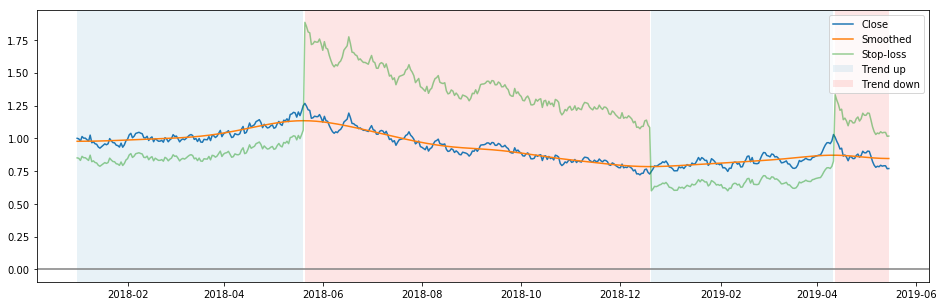

In [6]:
plot_trends(price_df)

## Dataset Class

In [7]:
def get_trend(df, sd, min_icagr=None,
              targets=['Trend', 'Max_Drawdown', 'ICAGR', 'Bliss']):

    t_df = find_trends(df, sd)
    if min_icagr:
        t_df = clean_trends(t_df)

    t_df = t_df.loc[:, targets]
    if 'Trend' in targets:
        t_df.Trend = t_df.Trend.add(1).astype(np.long)  # 0 = Down, 1 = No Trend, 2 = Up.
    t_df = t_df.rename({t: t + '_' + str(sd) for t in targets}, axis=1)
    
    return t_df

In [8]:
class SimulatedPricesDataset(Dataset):
    """Simulated Prices Dataset"""
    def __init__(self, N, sim_fun, 
                 features=None,
                 targets=['Trend', 'Max_Drawdown', 'ATR', 'Bliss'],
                 sds=[5, 10, 20, 30], min_icagr=None,
                 Ch=None,
                 tech_windows=None,
                 transform=None):
        """
        Args:
            N (int): number of prices to simulate.
            sim_fun: function that returns a simulated price DataFrame: Date | OHLC.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.N = N
        self.sim_fun = sim_fun
        self.targets = targets
        self.features = features
        self.sds = sds
        self.min_icagr = min_icagr
        self.Ch = Ch
        self.tech_windows = tech_windows
        self.transform = transform
        self.samples = []
        
        for i in tqdm_notebook(range(N)):
            sim_df = self.sim_fun()
        
            targets_df = pd.concat(
                (get_trend(sim_df, s, min_icagr=self.min_icagr, targets=self.targets)
                 for s in self.sds),
                axis=1,
            )

            if self.tech_windows:
                sim_df = add_technical(add_changes(sim_df), windows=self.tech_windows)
            elif self.Ch:
                sim_df = add_changes(sim_df)

            if self.features:
                sim_df = sim_df[self.features]

            sample = {'features': sim_df, 'targets': targets_df}
            self.samples.append(sample)
        
        self.n_features = self.samples[0]['features'].shape[1]
        self.n_targets = self.samples[0]['targets'].shape[1]
        self.features_columns = self.samples[0]['features'].columns
        self.targets_columns = self.samples[0]['targets'].columns
    
    
    def __len__(self):
        return self.N
    
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [9]:
sim_dataset = SimulatedPricesDataset(10, lambda: sim_path(N=800),
                                     targets=['Trend'], sds = [20],
                                     min_icagr=0.3, tech_windows=[30, 100])

In [10]:
sim_dataset.n_features, sim_dataset.n_targets

(20, 1)

In [11]:
sim_j = sim_dataset[2]
print(sim_j['features'].shape, sim_j['targets'].shape)

(800, 20) (800, 1)


In [12]:
sim_j['features'].columns

Index(['Open', 'High', 'Low', 'Close', 'Ch', 'Ch2', 'Ch3', 'Ch4', 'SMA_30',
       'SMA_100', 'sigma2_SMA_30', 'sigma2_SMA_100', 'skew_SMA_30',
       'skew_SMA_100', 'kurt_SMA_30', 'kurt_SMA_100', 'Support_30',
       'Support_100', 'Resistance_30', 'Resistance_100'],
      dtype='object')

In [13]:
sim_j['features'].head().T

Date,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,2018-01-04 00:00:00,2018-01-05 00:00:00
Open,1.000519,1.011577e+00,1.016253e+00,1.025132e+00,9.842086e-01
High,1.036294,1.039560e+00,1.023625e+00,1.030857e+00,1.060112e+00
Low,0.963654,9.884338e-01,9.793427e-01,9.670523e-01,9.811258e-01
Close,1.000000,9.911027e-01,1.011484e+00,1.010153e+00,1.024588e+00
Ch,0.000000,-8.937080e-03,2.035539e-02,-1.316144e-03,1.418886e-02
Ch2,0.000000,7.987140e-05,4.143421e-04,1.732234e-06,2.013237e-04
Ch3,0.000000,-7.138171e-07,8.434097e-06,-2.279868e-09,2.856553e-06
Ch4,0.000000,6.379440e-09,1.716794e-07,3.000634e-12,4.053122e-08
SMA_30,1.000000,9.955514e-01,1.000862e+00,1.003185e+00,1.007466e+00
SMA_100,1.000000,9.955514e-01,1.000862e+00,1.003185e+00,1.007466e+00


In [14]:
sim_j['targets'].head().T

Date,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,2018-01-04 00:00:00,2018-01-05 00:00:00
Trend_20,2,2,2,2,2


## Transforms

In [15]:
class ToArray(object):
    def __call__(self, sample):
        features, targets = sample['features'], sample['targets']
        return {'features': features.values, 'targets': targets.values}
        

class RandomCrop(object):
    """Crops randomly an inner segment of the time series.
    
    Args:
        output_size (int): length of the desired time series.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def __call__(self, sample):
        features, targets = sample['features'], sample['targets']
        
        size = len(features)
        if self.output_size < size:
            start = np.random.randint(0, size - self.output_size)
            features = features[start: start + self.output_size, :]
            targets = targets[start: start + self.output_size, :]
        
        return {'features': features, 'targets': targets}


class StartAt(object):
    def __init__(self, at):
        assert at > 0
        self.at = at
    
    def __call__(self, sample):
        features, targets = sample['features'], sample['targets']
        # Open starts at self.at
        features[:, :4] = self.at * features[:, :4] / features[0, 0]
        
        return {'features': features, 'targets': targets}
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        features, targets = sample['features'], sample['targets']

        return {'features': torch.from_numpy(features), 
                'targets': torch.from_numpy(targets)}

In [16]:
# sim_dataset = SimulatedPricesDataset(...,
#                                      transform=transforms.Compose([
#                                          ToArray(), RandomCrop(480)
#                                      ])
#                                     )

sim_dataset.transform = transforms.Compose([ToArray(), RandomCrop(480)])

(480, 20) (480, 1)


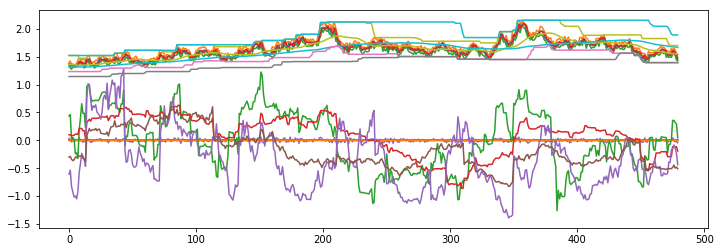

In [17]:
sim_j = sim_dataset[2]
print(sim_j['features'].shape, sim_j['targets'].shape)
plt.plot(sim_j['features']);

In [18]:
composed = transforms.Compose([ToArray(), RandomCrop(480), StartAt(100), ToTensor()])

sim_dataset.transform = composed

In [19]:
sim_j = sim_dataset[2]
print(sim_j['features'].size(), sim_j['targets'].size())

torch.Size([480, 20]) torch.Size([480, 1])


In [20]:
sim_j['features'][:6, :4]

tensor([[ 100.0000,  103.6370,   94.5519,   98.2206],
        [ 100.4753,  104.7136,   96.6290,   99.3158],
        [ 102.1351,  102.8091,   99.2322,  100.0442],
        [  97.2599,  103.6160,   94.6677,  101.9103],
        [  98.5077,  100.7020,   95.9298,   97.3787],
        [ 103.3817,  105.6665,   98.0384,   99.2823]], dtype=torch.float64)

In [21]:
sim_j['targets'][:6, :]

tensor([[ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2]])

## Iterating through the dataset

In [22]:
sds = [20]
tech_win = [10]
min_icagr = 0.3

train_dataset = SimulatedPricesDataset(1000, lambda: sim_path(N=500),
                                       targets=['Trend'],
                                       sds=sds, min_icagr=min_icagr,
                                       tech_windows=tech_win,
                                       transform=transforms.Compose([
                                           ToArray(),
                                           RandomCrop(480),
                                           ToTensor()
                                       ]))

test_dataset = SimulatedPricesDataset(50, lambda: sim_path(N=300),
                                      targets=['Trend'],
                                      sds=sds, min_icagr=min_icagr,
                                      tech_windows=tech_win,
                                      transform=transforms.Compose([
                                          ToArray(),
                                          ToTensor()
                                      ]))

//anaconda/envs/trend/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [23]:
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

print('Train:')
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['features'].size(),
          sample_batched['targets'].size())
    
    if i_batch == 5:
        break

print('Test:')
for i_batch, sample_batched in enumerate(test_loader):
    print(i_batch, sample_batched['features'].size(),
          sample_batched['targets'].size())
    
    if i_batch == 5:
        break

Train:
0 torch.Size([50, 480, 14]) torch.Size([50, 480, 1])
1 torch.Size([50, 480, 14]) torch.Size([50, 480, 1])
2 torch.Size([50, 480, 14]) torch.Size([50, 480, 1])
3 torch.Size([50, 480, 14]) torch.Size([50, 480, 1])
4 torch.Size([50, 480, 14]) torch.Size([50, 480, 1])
5 torch.Size([50, 480, 14]) torch.Size([50, 480, 1])
Test:
0 torch.Size([50, 300, 14]) torch.Size([50, 300, 1])


In [24]:
input = next(iter(train_loader))['features']
list(input.chunk(input.size(1), dim=1))[479].shape

torch.Size([50, 1, 14])

## LSTM Model

> // Multiple dimension softmax and `NLLLoss`, for Trend_5, Trend_10, etc.
>
> // Weights in loss function: prob(no trend) really low.

In [83]:
class Sequence(nn.Module):
    def __init__(self, h0=1, h1=51, h2=51, hL=3, warmup=60, nll_weights=None):
        super(Sequence, self).__init__()
        self.h0 = h0
        self.h1 = h1
        self.h2 = h2
        self.hL = hL
        self.lstm1 = nn.LSTMCell(h0, h1)
        self.lstm2 = nn.LSTMCell(h1, h2)
        self.linear = nn.Linear(h2, hL)
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.warmup = 60
        self.loss_fun = nn.NLLLoss(weight=nll_weights)
        
    
    def init_hidden(self):
        self.h_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        self.c_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        self.h_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)
        self.c_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)

    
    def forward(self, input):
        self.init_hidden()
        outputs = []
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            self.h_t, self.c_t = self.lstm1(input_t.view(-1, self.h0), (self.h_t, self.c_t))
            self.h_t2, self.c_t2 = self.lstm2(self.h_t, (self.h_t2, self.c_t2))
            output = self.linear(self.h_t2)
            output = self.softmax(output)
            outputs += [output]

        outputs = torch.stack(outputs, 1)
        return outputs
    

    def loss(self, y_hat, y_true):
        loss = 0
        for i in range(self.warmup, y_hat.size()[1]):
            loss = loss + self.loss_fun(y_hat[:, i, :], y_true[:, i, :].squeeze(dim=1))
        return loss / (y_hat.size()[1] - self.warmup)

In [ ]:
Series(np.concatenate([sim_j['targets'].numpy().flatten() for sim_j in sim_dataset])).value_counts()

In [96]:
_, freqs = np.unique([sim_j['targets'].numpy().flatten() for sim_j in train_dataset], return_counts=True)
weights = torch.Tensor(freqs / sum(freqs))

In [86]:
# build the model
seq = Sequence(h0=train_dataset.n_features, nll_weights=weights)
seq.double()

Sequence(
  (lstm1): LSTMCell(14, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=3, bias=True)
  (softmax): LogSoftmax()
  (loss_fun): NLLLoss()
)

In [87]:
sample = next(iter(train_loader))
inputs = sample['features']
targets = sample['targets']

In [88]:
out = seq(inputs)

In [89]:
out.size(), targets.size()

(torch.Size([50, 480, 3]), torch.Size([50, 480, 1]))

In [90]:
seq.loss(out, targets)

tensor(1.1239, dtype=torch.float64)

In [91]:
test_sample = next(iter(test_loader))
test_inputs = test_sample['features']
test_targets = test_sample['targets']

In [92]:
with torch.no_grad():
    test_out = seq(test_inputs)
test_out.size()

torch.Size([50, 300, 3])

In [93]:
seq.loss(test_out, test_targets)

tensor(1.1103, dtype=torch.float64)

### Train

#### Find lr

In [94]:
losses = []
lrs = np.exp(np.arange(np.log(1e-6), np.log(1), step=0.1))
sched_lrs = []
optimizer = optim.Adam(seq.parameters(), lr=1)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: lrs[epoch])


for e in tqdm_notebook(np.arange(len(lrs) // (len(train_dataset) / train_loader.batch_size) + 1),
                       desc='Epoch:'):

    for i_batch, sample_batched in tqdm_notebook(enumerate(train_loader), desc='Mini-batch:', leave=False):
        inputs, targets = sample_batched['features'], sample_batched['targets']
        scheduler.step()
        sched_lrs.append(scheduler.get_lr())
        def closure():
            optimizer.zero_grad()
            out = seq(inputs)
            loss = seq.loss(out, targets)
            losses.append(loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
        
        if scheduler.last_epoch == len(lrs) - 1: break
    if scheduler.last_epoch == len(lrs) - 1: break


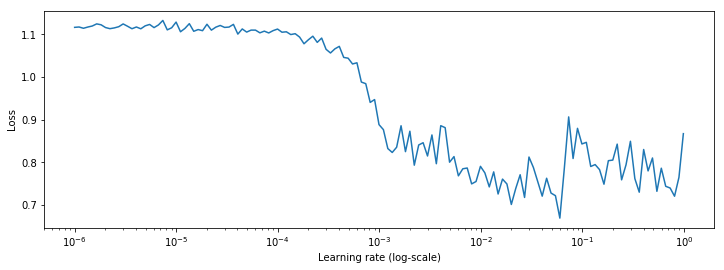

In [95]:
plt.semilogx(np.array(sched_lrs).flatten()[:250], losses[:250])
plt.xlabel('Learning rate (log-scale)')
plt.ylabel('Loss')
plt.show()

#### Train the model

In [97]:
losses = []
test_losses = []
seq = Sequence(h0=train_dataset.n_features, nll_weights=weights)
seq.double()

Sequence(
  (lstm1): LSTMCell(14, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=3, bias=True)
  (softmax): LogSoftmax()
  (loss_fun): NLLLoss()
)

In [115]:
optimizer = optim.Adam(seq.parameters(), lr=1e-4)
# optimizer = optim.SGD(seq.parameters(), lr=1e-3, momentum=0.9)

In [116]:
epochs = 10
for e in tqdm_notebook(range(epochs), desc='Epoch:'):
    
    for i_batch, sample_batched in tqdm_notebook(enumerate(train_loader), desc='Mini-batch:', leave=False):
        inputs, targets = sample_batched['features'], sample_batched['targets']
    
        def closure():
            optimizer.zero_grad()
            out = seq(inputs)
            loss = seq.loss(out, targets)
            losses.append(loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
    
    if e % 1 == 0:
        with torch.no_grad():
            test_sample = next(iter(test_loader))
            test_inputs, test_targets = test_sample['features'], test_sample['targets']
            test_out = seq(test_inputs)
            test_loss = seq.loss(test_out, test_targets)
            test_losses.append(test_loss.item())
        print('Epoch: ', e,
              ', training loss: ', np.mean(losses[-(len(train_dataset) // train_loader.batch_size):]),
              ', test loss: ', test_loss.item(), sep='')


Epoch: 0, training loss: 0.6959984932100256, test loss: 0.758437879921061


Epoch: 1, training loss: 0.6934497047750812, test loss: 0.7582789784238455


Epoch: 2, training loss: 0.6937716332477409, test loss: 0.756387478398797


Epoch: 3, training loss: 0.6928217132565851, test loss: 0.7558873149497315


Epoch: 4, training loss: 0.6933980075242903, test loss: 0.7556627411376763


Epoch: 5, training loss: 0.6918859664140873, test loss: 0.7549143899937315


Epoch: 6, training loss: 0.6918120202663062, test loss: 0.7542905581698034


Epoch: 7, training loss: 0.6911097395588419, test loss: 0.7544207195773296


Epoch: 8, training loss: 0.6903377705400484, test loss: 0.7533493032687466


Epoch: 9, training loss: 0.6902901073449019, test loss: 0.7525716209955368


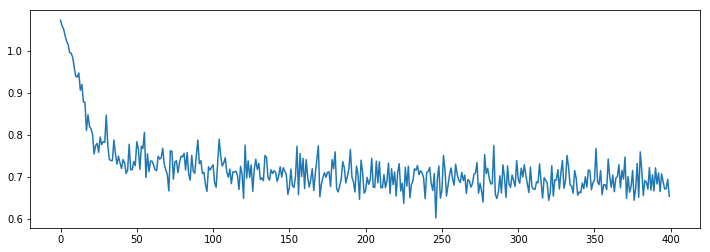

In [125]:
plt.plot(losses)

In [118]:
test_sample = next(iter(test_loader))
test_inputs, test_targets = test_sample['features'], test_sample['targets']
test_out = seq(test_inputs)

In [119]:
j = np.random.randint(len(test_dataset))
features_j = test_inputs[j, ...]
x_j = pd.DataFrame(features_j.numpy(), columns=test_dataset.features_columns)

In [120]:
targets_j = test_targets[j, ...]
y_j = pd.DataFrame(targets_j.numpy(), columns=test_dataset.targets_columns)

In [121]:
out_j = test_out[j, ...]
yh_j = pd.DataFrame(np.exp(out_j.detach().numpy()), columns=['Down', 'No_Trend', 'Up'])
yh_j = yh_j.assign(y_hat = pd.DataFrame(np.exp(out_j.detach().numpy())).idxmax(axis=1))

In [122]:
confusion_matrix(y_j.values, yh_j.y_hat)/len(y_j)

array([[0.11333333, 0.        , 0.21666667],
       [0.06666667, 0.        , 0.11      ],
       [0.12666667, 0.        , 0.36666667]])

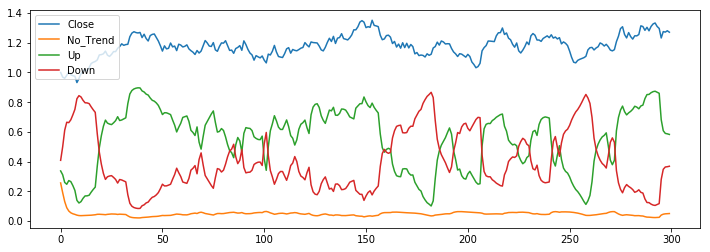

In [123]:
res_j = pd.concat((x_j, y_j, yh_j), axis=1)
res_j[['Close', 'No_Trend', 'Up', 'Down']].plot()

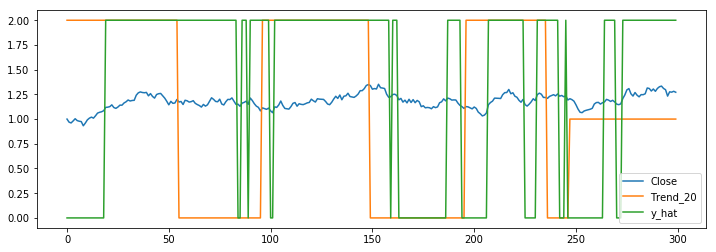

In [124]:
res_j[['Close', 'Trend_20', 'y_hat']].plot()

# Sharadar prices //

> // How to manage train and validation samples?

In [ ]:
class SharadarPricesDataset(Dataset):
    """Sharadar Prices Dataset"""
    def __init__(self, root_dir, min_length,
                 features=None,
                 targets=['Trend', 'Max_Drawdown', 'ATR', 'Bliss'],
                 sds=[5, 10, 20, 30], min_icagr=None, 
                 transform=None):
        """
        Args:
            root_dir (str): directory with data frames: Date | OHLC.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.min_length = min_length
        self.targets = targets
        self.features = features
        self.sds = sds
        self.min_icagr = min_icagr
        self.transform = transform
        
        # Only series longer than min_length
        tickers = os.listdir(root_dir)
        lengths = [len(pd.read_feather(os.path.join(root_dir, f)))
                   for f in tickers]
        tickers_df = DataFrame(data={'ticker': tickers, 'length': lengths})
        self.fnames = list(
            tickers_df.query('length > ' + str(self.min_length)).ticker.values
        )
    
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        
        f_name = os.path.join(self.root_dir,
                              self.fnames[idx])
        
        df = pd.read_feather(f_name).set_index('Date')
        
        targets_df = pd.concat(
            (get_trend(df, s, min_icagr=self.min_icagr, targets=self.targets)
             for s in self.sds),
            axis=1,
        )
        
        if self.features:
            df = df[self.features]
        
        sample = {'features': df, 'targets': targets_df}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [ ]:
sh_train = 'input/Quandl/Sharadar/train/'

sh_dataset = SharadarPricesDataset(sh_train, min_length=600, min_icagr=0.3)
print(len(sh_dataset), 'series.')

In [ ]:
sh_j = sh_dataset[2]
print(sh_j['features'].shape, sh_j['targets'].shape)

In [ ]:
sh_j['features'].head().T

In [ ]:
sh_j['targets'].head().T

## Transforms

In [ ]:
# sh_train = 'input/Quandl/Sharadar/train/'
# sh_dataset = SharadarPricesDataset(sh_train, min_length=600, min_icagr=0.3,
#                                    transform=transforms.Compose([
#                                        ToArray(),
#                                        RandomCrop(500),
#                                        StartAt(1),
#                                        ToTensor(),
#                                      ])
#                                    )

In [ ]:
composed = transforms.Compose([
    ToArray(),
    RandomCrop(300),
    StartAt(1),
    ToTensor()
])

sh_dataset.transform = composed
print(len(sh_dataset), 'series.')

In [ ]:
sh_j = sh_dataset[2]
print(sh_j['features'].size(), sh_j['targets'].size())

In [ ]:
plt.plot(sh_j['features'][:, :4].numpy());

In [ ]:
plt.plot(sh_j['features'][:, 4].numpy());

In [ ]:
plt.plot(sh_j['features'][:, 5:].numpy());

## DataLoader

In [ ]:
sh_loader = DataLoader(sh_dataset, batch_size=6)

for i_batch, sample_batched in enumerate(sh_loader):
    print(i_batch, sample_batched['features'].size(),
          sample_batched['targets'].size())
    
    if i_batch == 5:
        break

# End

In [ ]:
df = pd.read_feather('input/Quandl/Sharadar/train/NIOBF.feather').set_index('Date')
df = find_trends(df)

In [ ]:
df

In [ ]:
(df.Trend_End - df.Trend_Start).min()

In [ ]:
plot_trends(df)

In [ ]:
df.Ratio.dropna().sort_values()

# TO DO:

* Check why the ratio is < 0.
* `SharadarPricesDataset` that computes data and saves it to disk on `__init__`, and only loads df on `__get_item__`.